In [1]:
%load_ext autoreload
%env CUDA_VISIBLE_DEVICES=0
import sys
sys.path.append('..')

env: CUDA_VISIBLE_DEVICES=0


In [2]:
%autoreload
from graph_augmented_pt.utils.tensorboard_utils import *

from graphlet_atlas import *
from synthetic_datasets import *
from synthetic_runner import *
from simplicial_manfiolds import *

import matplotlib, pandas as pd
pd.options.mode.chained_assignment = None 
%matplotlib inline

from collections import Counter, defaultdict
import copy, itertools, json, logging, math, os, pickle, scipy, shutil, time, numpy as np
from tqdm.notebook import tqdm
from scipy.stats import spearmanr

from pathlib import Path
from IPython.display import Image 

In [3]:
def nCr(n,r):
    f = math.factorial
    return int(f(n) / f(r) / f(n-r))

# Generating Synthetic Data

In [139]:
RAW_FILEPATH = '/crimea/graph_augmented_pt/synthetic_datasets/wikisent2.txt'
PKL_FILEPATH = '/crimea/graph_augmented_pt/synthetic_datasets/wikisent2_feat.pkl'
SIMPLEX_ORDER_FILEPATH = '/crimea/graph_augmented_pt/synthetic_datasets/topics_to_try.pkl'
TOPIC_CLIQUE_FILEPATH = '/crimea/graph_augmented_pt/synthetic_datasets/topic_clique.json'

assert os.path.isfile(RAW_FILEPATH)
assert os.path.isfile(PKL_FILEPATH)

# Source: https://www.kaggle.com/mikeortman/wikipedia-sentences
with open(RAW_FILEPATH, mode='r') as f: text_data = f.readlines()

with open(PKL_FILEPATH, mode='rb') as f:
    X, LDA, topics, first_topic, sents_by_topic, topic_correlations = pickle.load(f)
n_sents_by_topic = {t: len(sents) for t, sents in sents_by_topic.items()}

with open(SIMPLEX_ORDER_FILEPATH, mode='rb') as f:
    topics_to_try = pickle.load(f)
    
with open(TOPIC_CLIQUE_FILEPATH, mode='r') as f:
    topic_clique_hint = json.loads(f.read())

Exception ignored in: <function tqdm.__del__ at 0x7f4dafc060d0>
Traceback (most recent call last):
  File "/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/tqdm/std.py", line 1121, in __del__
    def __del__(self):
KeyboardInterrupt: 


##### A third different Approach

In [132]:
def expand(tset, valid_simplices, base_ts=np.arange(100)):
    tset = list(tset)

    ts = []
    for t1 in set(base_ts) - set(tset):
        can_include = True
        for t2, t3 in itertools.combinations(tset, 2):
            if not frozenset((t1, t2, t3)) in valid_simplices:
                can_include = False
                break
                
        if can_include: ts.append(t1)
        
    return set(ts)
        
def maximally_expand(tset, valid_simplices, base_ts=np.arange(100), depth=0, memoization_dict=None):
    if memoization_dict is None: memoization_dict = {}
        
    if frozenset(tset) in memoization_dict: return memoization_dict[frozenset(tset)]
        
    ts = expand(tset, valid_simplices, base_ts=base_ts)
    if len(ts) == 0: return tset
    
    max_opt = tset
    ts_rng = ts if (depth > 2 or len(ts) < 10) else tqdm(ts, leave=False, desc="Expanding")
    for t in ts_rng:
        query_tset = frozenset([t, *tset])
        new_tset = maximally_expand(
            query_tset, valid_simplices, depth=depth+1, memoization_dict=memoization_dict
        )
        memoization_dict[query_tset] = new_tset
        
        if len(new_tset) > len(max_opt): max_opt = new_tset
            
    return max_opt

In [133]:
fake_valid_simplices = set(
    frozenset(s) for s in list(itertools.combinations(np.arange(6), 3)) + [(0, 1, 7), (7, 8, 9), (4, 8, 9)]
)

fake_valid_simplices_list = list(fake_valid_simplices)
random.shuffle(fake_valid_simplices_list)

o = []
for s in fake_valid_simplices_list:
    m = maximally_expand(s, fake_valid_simplices)
    if len(m) > len(o): o = m
        
print(o)

frozenset({0, 1, 2, 3, 4, 5})


In [135]:
topics_cp               = copy.deepcopy(topics)
min_sents_per_simplex   = 25
topics_thresh           = 2/3

N = len(topics_cp)

top_3_st = time.time()
first_topics  = np.argmax(topics_cp, axis=1)
topics_cp[np.arange(N), first_topics] = 0
second_topics = np.argmax(topics_cp, axis=1)
topics_cp[np.arange(N), second_topics] = 0
third_topics = np.argmax(topics_cp, axis=1)
top_3_end = time.time()

reindex_st = time.time()
top_3 = np.vstack((first_topics, second_topics, third_topics)).T
top_3_probs = topics[np.arange(N), [first_topics, second_topics, third_topics]].T

obs_probability_mass = top_3_probs.sum(axis=1)
valid_sents_mask = (obs_probability_mass > topics_thresh)
valid_sents_idx,  = np.where(valid_sents_mask)

topics_cp   = topics_cp[valid_sents_mask]
top_3       = top_3[valid_sents_mask]
top_3_probs = top_3_probs[valid_sents_mask]
reindex_end = time.time()

print(
    f"Dropping {len(topics) - len(top_3)} sentences as they lack sufficient probability mass in their top-3.\n"
    f"It took {(reindex_end - reindex_st)/60:.1f} minutes to do that check & drop."
)

cnt_assignments_st = time.time()
all_observed_topic_simplices = Counter(frozenset(t) for t in top_3)
cnt_assignments_end = time.time()

print(
    f"Observe {len(all_observed_topic_simplices)} simplices (of {nCr(100, 3)} total possible) "
    f"in total across {len(topics_cp)} sentences.\n"
    f"It took {(top_3_end - top_3_st)/60:.1f} minutes to get the top 3 topics / sent and "
    f"{(cnt_assignments_end - cnt_assignments_st)/60:.1f} minutes to get the counts."
)

first_filtering_st      = time.time()
valid_simplices         = set(k for k, v in all_observed_topic_simplices.items() if v >= min_sents_per_simplex)
valid_simplex_checker   = lambda np_arr: np.array([frozenset(row) in valid_simplices for row in np_arr])
sufficiently_dense_mask = valid_simplex_checker(top_3)

topics_cp               = topics_cp[sufficiently_dense_mask]
top_3                   = top_3[sufficiently_dense_mask]
top_3_probs             = top_3_probs[sufficiently_dense_mask]
valid_sents_idx         = valid_sents_idx[sufficiently_dense_mask]
first_filtering_end     = time.time()

print(
    f"After filtering out insufficiently dense simplices, we have {len(valid_simplices)}/{len(topics_cp)} "
    f"simplices / sentences, respectively. This process took "
    f"{(first_filtering_end - first_filtering_st)/60:.1f} minutes"
)

global_selection = []
containing_maximal_cliques = {}

Dropping 2178743 sentences as they lack sufficient probability mass in their top-3.
It took 0.0 minutes to do that check & drop.
Observe 158547 simplices (of 161700 total possible) in total across 5693082 sentences.
It took 0.0 minutes to get the top 3 topics / sent and 0.2 minutes to get the counts.
After filtering out insufficiently dense simplices, we have 46965/4645898 simplices / sentences, respectively. This process took 0.2 minutes


In [1]:
from collections import defaultdict

In [2]:
 a = defaultdict(defaultdict(dict))

TypeError: first argument must be callable or None

In [3]:
a = defaultdict(lambda: defaultdict(dict))

In [5]:
a[3][4] = 5

In [6]:
a

defaultdict(<function __main__.<lambda>()>, {3: defaultdict(dict, {4: 5})})

In [ ]:
to_complete_subgraph_st = time.time() 
valid_simplices_list = list(valid_simplices)
random.shuffle(valid_simplices_list)

valid_simplices_rng = tqdm(
    np.arange(len(valid_simplices_list)), desc="Complete Subgraph: 3 so far"
)
for tset_idx in valid_simplices_rng:
    tset = valid_simplices_list[tset_idx]
    
    max_expansion = maximally_expand(
        tset, valid_simplices, memoization_dict=containing_maximal_cliques, 
    )
    
    if len(max_expansion) <= len(global_selection): continue
        
    global_selection = max_expansion
    valid_simplices_rng.set_description(f"Complete Subgraph: {len(global_selection)} so far")
        
    # Given we found a new optimum, we want to take advantage of that.
    
    fresh_optima = True
    while fresh_optima:
        fresh_optima = False
        for subclique_size in range(len(global_selection)-1, 2, -1):
            for tset in itertools.combinations(global_selection, subclique_size):
                m = maximally_expand(tset, valid_simplices, memoization_dict=containing_maximal_cliques)
                if len(m) > len(global_selection):
                    global_selection = m
                    fresh_optima = True
        
valid_topics = global_selection
valid_simplices = {t_set for t_set in valid_simplices if t_set.issubset(valid_topics)}
assert len(valid_simplices) == nCr(len(valid_topics), 3)
    
simplex_valid_mask = np.array([frozenset(row) in valid_simplices for row in top_3])

topics_cp                = topics_cp[simplex_valid_mask]
top_3                    = top_3[simplex_valid_mask]
top_3_probs              = top_3_probs[simplex_valid_mask]
valid_sents_idx          = valid_sents_idx[simplex_valid_mask]
to_complete_subgraph_end = time.time()

print(
    "After filtering out simplices that are not universally compatible, we have "
    f"{len(valid_simplices)}/{len(topics_cp)} "
    f"simplices / sentences, respectively. This process took "
    f"{(to_complete_subgraph_end - to_complete_subgraph_st)/60:.1f} minutes"
)


normalization_st = time.time()
normalized = np.divide(top_3_probs, top_3_probs.sum(axis=1)[:, np.newaxis])
entropy    = -(normalized * np.log(normalized)).sum(axis=1)
entropy_per_simplex = defaultdict(list)
for i, (e, ts) in enumerate(zip(entropy, top_3)): entropy_per_simplex[frozenset(ts)].append(e)
    
agg_entropy_per_simplex = {
    k: (np.min(es), np.max(es), np.histogram(es)) for k, es in entropy_per_simplex.items()
}
normalization_end = time.time()

print(f"Normalizing & computing entropy took {(normalization_end - normalization_st)/60:.1f} minutes")

In [140]:
with open(TOPIC_CLIQUE_FILEPATH, mode='w') as f:
    f.write(
        json.dumps([int(t) for t in global_selection]),
    )

In [150]:
with open('/crimea/graph_augmented_pt/synthetic_datasets/topic_containing_maximal_cliques.pkl', mode='wb') as f:
    pickle.dump(containing_maximal_cliques, f)

In [116]:
A = copy.deepcopy(global_selection)

In [117]:
global_selection

[31, 60, 89, 24, 20, 42, 70, 10, 0, 65, 93]

##### A different Approach

In [ ]:
topics_cp               = copy.deepcopy(topics)
min_sents_per_simplex   = 100
topics_thresh           = 2/3
required_entropy_spread = (0.05, 0.95)

N = len(topics_cp)

top_3_st = time.time()
first_topics  = np.argmax(topics_cp, axis=1)
topics_cp[np.arange(N), first_topics] = 0
second_topics = np.argmax(topics_cp, axis=1)
topics_cp[np.arange(N), second_topics] = 0
third_topics = np.argmax(topics_cp, axis=1)
top_3_end = time.time()

reindex_st = time.time()
top_3 = np.vstack((first_topics, second_topics, third_topics)).T
top_3_probs = topics[np.arange(N), [first_topics, second_topics, third_topics]].T

obs_probability_mass = top_3_probs.sum(axis=1)
valid_sents_mask = (obs_probability_mass > topics_thresh)
valid_sents_idx,  = np.where(valid_sents_mask)

topics_cp   = topics_cp[valid_sents_mask]
top_3       = top_3[valid_sents_mask]
top_3_probs = top_3_probs[valid_sents_mask]
reindex_end = time.time()

print(
    f"Dropping {len(topics) - len(top_3)} sentences as they lack sufficient probability mass in their top-3.\n"
    f"It took {(reindex_end - reindex_st)/60:.1f} minutes to do that check & drop."
)

cnt_assignments_st = time.time()
all_observed_topic_simplices = Counter(frozenset(t) for t in top_3)
cnt_assignments_end = time.time()

print(
    f"Observe {len(all_observed_topic_simplices)} simplices (of {nCr(100, 3)} total possible) "
    f"in total across {len(topics_cp)} sentences.\n"
    f"It took {(top_3_end - top_3_st)/60:.1f} minutes to get the top 3 topics / sent and "
    f"{(cnt_assignments_end - cnt_assignments_st)/60:.1f} minutes to get the counts."
)

first_filtering_st      = time.time()
valid_simplices         = set(k for k, v in all_observed_topic_simplices.items() if v >= min_sents_per_simplex)
valid_simplex_checker   = lambda np_arr: np.array([frozenset(row) in valid_simplices for row in np_arr])
sufficiently_dense_mask = valid_simplex_checker(top_3)

topics_cp               = topics_cp[sufficiently_dense_mask]
top_3                   = top_3[sufficiently_dense_mask]
top_3_probs             = top_3_probs[sufficiently_dense_mask]
valid_sents_idx         = valid_sents_idx[sufficiently_dense_mask]
first_filtering_end     = time.time()

print(
    f"After filtering out insufficiently dense simplices, we have {len(valid_simplices)}/{len(topics_cp)} "
    f"simplices / sentences, respectively. This process took "
    f"{(first_filtering_end - first_filtering_st)/60:.1f} minutes"
)

normalization_st = time.time()
normalized = np.divide(top_3_probs, top_3_probs.sum(axis=1)[:, np.newaxis])
entropy    = -(normalized * np.log(normalized)).sum(axis=1)
entropy_per_simplex = defaultdict(list)
for i, (e, ts) in enumerate(zip(entropy, top_3)): entropy_per_simplex[frozenset(ts)].append(e)
    
agg_entropy_per_simplex = {
    k: (np.min(es), np.max(es), np.histogram(es)) for k, es in entropy_per_simplex.items()
}
normalization_end = time.time()

print(f"Normalizing & computing entropy took {(normalization_end - normalization_st)/60:.1f} minutes")

entropy_filtering_st = time.time()
def sufficient_entropy_spread_fn(row):
    obs_mn, obs_mx, _ = agg_entropy_per_simplex[frozenset(row)]
    req_mn, req_mx = required_entropy_spread
    
    return (obs_mn <= req_mn*(-np.log(1/3))) and (obs_mx >= req_mx*(-np.log(1/3)))

valid_simplices                = {s for s in valid_simplices if sufficient_entropy_spread_fn(s)}
sufficient_entropy_spread_mask = np.array([frozenset(row) in valid_simplices for row in top_3])
topics_cp                      = topics_cp[sufficient_entropy_spread_mask]
top_3                          = top_3[sufficient_entropy_spread_mask]
top_3_probs                    = top_3_probs[sufficient_entropy_spread_mask]
valid_sents_idx                = valid_sents_idx[sufficient_entropy_spread_mask]

normalized                     = normalized[sufficient_entropy_spread_mask]
entropy                        = entropy[sufficient_entropy_spread_mask]

entropy_filtering_end = time.time()

print(
    "After filtering out insufficiently well-spread simplices, we have "
    f"{len(valid_simplices)}/{len(topics_cp)} "
    f"simplices / sentences, respectively. This process took "
    f"{(entropy_filtering_end - entropy_filtering_st)/60:.1f} minutes"
)

print("All done filtering. Setting up derived data.")

sentence_splitting_st = time.time()
sentences_by_simplex = {}

downstream_rng = tqdm(list(zip(valid_sents_idx, top_3, top_3_probs, normalized, entropy)), desc="Sents")
for idx, ts, probs, normeds, ent in downstream_rng:
    simplex = frozenset(ts)
    
    sentence = text_data[idx]
    orig_probs = topics[idx]
    
    assert (topics[idx, ts] == probs).all(), f"{topics[idx, ts]} vs. {probs}"
    assert (probs / probs.sum() == normeds).all(), f"{probs / probs.sum()} vs. {normeds}"
    
    _, _, (hist_counts, hist_bounds) = agg_entropy_per_simplex[simplex]
    hist_ps = (hist_counts / hist_counts.sum())
    
    try:
        bound_idx = next(
            i for i in range(len(hist_bounds) - 1) if ent >= hist_bounds[i] and ent < hist_bounds[i+1]
        )
    except StopIteration as e:
        if ent == hist_bounds[-1]: bound_idx = len(hist_bounds) - 2
        else:
            print("What?", ent, hist_bounds)
            assert False
        
    entropy_empirical_probability = hist_ps[bound_idx]
        
    if simplex not in sentences_by_simplex: sentences_by_simplex[simplex] = {
        'sents': [], 'likelihoods': [], 'coords': [], 'idxs': []
    }
        
    sentences_by_simplex[simplex]['sents'].append(sentence)
    sentences_by_simplex[simplex]['coords'].append({t: np for t, np in zip(ts, normeds)})
    sentences_by_simplex[simplex]['likelihoods'].append(1 / entropy_empirical_probability)
    sentences_by_simplex[simplex]['idxs'].append(idx)

sentence_splitting_end = time.time()

print(
    "Split all the sentences by simplex and calculated other properties. "
    f"Took {(sentence_splitting_end - sentence_splitting_st) / 60:.1f} minutes."
)

topic_graph_construction_st = time.time()
topic_graph = nx.Graph()

all_topics = set().union(*valid_simplices)
topic_graph.add_nodes_from(all_topics, type='topics')

# We'll connect topic nodes to one another with bidirectional edges.
topic_bidirectional_edges = []
topic_graph.add_edges_from((
    (t1, t2) for tset in valid_simplices for t1, t2 in itertools.permutations(tset, 2)
))

# Now we'll add topic-simplex nodes, connecting each simplex (in a directed manner) to its member
# topics.
topic_graph.add_nodes_from(
    [frozenset(tset) for tset in valid_simplices], type='simplex'
)
topic_graph.add_edges_from(
    (frozenset(tset), t) for tset in valid_simplices for t in tset
)
topic_graph_construction_end = time.time()

print(
    "Constructed directed topic graph in "
    f"{(topic_graph_construction_end - topic_graph_construction_st):.1f} minutes."
)

In [ ]:
GM = nx.algorithms.isomorphism.GraphMatcher(topic_graph, D.manifold.full_G)

In [ ]:
GM.subgraph_is_isomorphic()

In [ ]:
3

In [535]:
valid_simplices

{frozenset({0, 34, 59}),
 frozenset({0, 6, 40}),
 frozenset({0, 19, 80}),
 frozenset({0, 63, 94}),
 frozenset({0, 65, 93}),
 frozenset({0, 2, 29}),
 frozenset({0, 54, 98}),
 frozenset({0, 52, 99}),
 frozenset({26, 41, 98}),
 frozenset({0, 6, 9}),
 frozenset({0, 33, 72}),
 frozenset({0, 60, 65}),
 frozenset({0, 1, 64}),
 frozenset({0, 1, 60}),
 frozenset({0, 23, 68}),
 frozenset({0, 33, 74}),
 frozenset({0, 33, 68}),
 frozenset({0, 17, 42}),
 frozenset({0, 33, 46}),
 frozenset({0, 1, 67}),
 frozenset({0, 1, 40}),
 frozenset({0, 19, 37}),
 frozenset({0, 6, 52}),
 frozenset({0, 6, 99}),
 frozenset({0, 1, 73}),
 frozenset({0, 42, 65}),
 frozenset({0, 22, 39}),
 frozenset({0, 52, 66}),
 frozenset({0, 1, 94}),
 frozenset({0, 34, 97}),
 frozenset({2, 6, 46}),
 frozenset({0, 33, 52}),
 frozenset({0, 1, 41}),
 frozenset({0, 10, 93}),
 frozenset({0, 1, 32}),
 frozenset({0, 34, 73}),
 frozenset({0, 29, 83}),
 frozenset({15, 29, 34}),
 frozenset({0, 6, 46}),
 frozenset({6, 52, 53}),
 frozenset({0,

In [ ]:
while True:
    try:
        st = random.choice(list(valid_simplices))
        boundary = set(list(st)[:2])
        st_missing = st - boundary
        used = {*st}

        path = [st]
        for i in range(6):
            nxt = next(s for s in valid_simplices if boundary.issubset(s) and not used.issuperset(s - boundary))
            path.append(nxt)
            used.update(nxt)
            choice = random.choice((0, 1))
            boundary = {list(nxt - boundary)[0], list(boundary)[choice]}

        end =  next(
            s for s in valid_simplices if \
            len(s.intersection(nxt)) == 2 and len(s.intersection(st)) == 2 and st_missing in s.intersection(st) and
            s.intersection(nxt) != s.intersection(st)
        )
        path.append(end)
        break
    except: pass

In [584]:
path

[frozenset({0, 80, 90}),
 frozenset({0, 19, 80}),
 frozenset({0, 19, 37}),
 frozenset({0, 37, 85}),
 frozenset({0, 1, 85}),
 frozenset({0, 1, 64}),
 frozenset({0, 34, 64}),
 frozenset({0, 34, 80})]

In [585]:
M = LabeledSimplicialManifold([list(s) for s in path])

AssertionError: 

No planar embedding exists: G is not planar.
Trying neato
Manifold has 7 simplices


(<Figure size 720x360 with 2 Axes>,
 (<AxesSubplot:title={'center':'Simplicial Complex (all vertices)'}>,
  <AxesSubplot:title={'center':'Simplicial Complex (node per simplex)'}>))

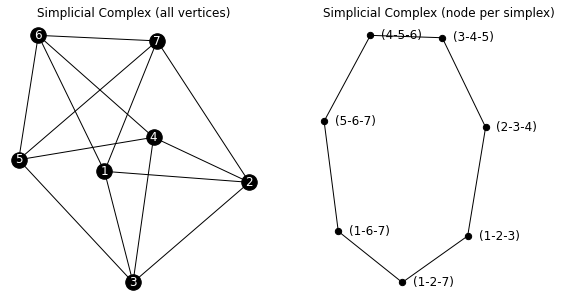

In [508]:
D.manifold.display()

In [466]:
random.choice((0, 1))

0

In [404]:
normalized

array([[0.48086374, 0.28279861, 0.23633765],
       [0.54077469, 0.23329581, 0.2259295 ],
       [0.70201429, 0.16344218, 0.13454353],
       ...,
       [0.46636995, 0.31244716, 0.22118289],
       [0.72294408, 0.17640712, 0.1006488 ],
       [0.74098875, 0.25776592, 0.00124533]])

In [408]:
normalized[entropy < 0.2]

array([[9.98949028e-01, 5.25486075e-04, 5.25486075e-04],
       [9.99001498e-01, 4.99251123e-04, 4.99251123e-04],
       [9.98465081e-01, 7.67459708e-04, 7.67459708e-04],
       ...,
       [9.95037221e-01, 2.48138958e-03, 2.48138958e-03],
       [9.97155050e-01, 1.42247511e-03, 1.42247511e-03],
       [9.98669328e-01, 6.65335996e-04, 6.65335995e-04]])

(array([2.6404e+05, 8.2902e+04, 1.0608e+04, 0.0000e+00, 4.0000e+00,
        2.6000e+01, 1.1200e+02, 2.1300e+02, 4.7700e+02, 1.0050e+03]),
 array([0.00367357, 0.02330362, 0.04293367, 0.06256372, 0.08219377,
        0.10182382, 0.12145387, 0.14108392, 0.16071397, 0.18034402,
        0.19997407]),
 <BarContainer object of 10 artists>)

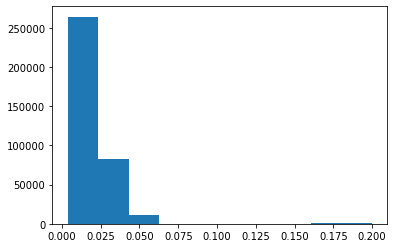

In [407]:
plt.hist(entropy[entropy < 0.2])

(array([357564.,   4357.,  51145., 100097., 127981., 193576., 259622.,
        256466., 583169., 982993.]),
 array([0.00367357, 0.11316744, 0.22266132, 0.33215519, 0.44164906,
        0.55114293, 0.6606368 , 0.77013067, 0.87962455, 0.98911842,
        1.09861229]),
 <BarContainer object of 10 artists>)

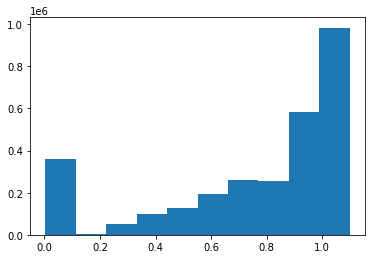

In [400]:
plt.hist(entropy)

In [395]:
sufficiently_dense_mask

array([[False, False, False],
       [False, False, False],
       [False, False, False],
       ...,
       [False, False, False],
       [False, False, False],
       [False, False, False]])

In [393]:
valid_simplex_checker   = np.vectorize(lambda row: row in valid_simplices, [bool])

In [383]:
print(invalid_sents_mask.sum())

2178743


In [372]:
all_observed_topic_simplices

Counter({frozenset({10, 40, 64}): 20,
         frozenset({26, 36, 77}): 100,
         frozenset({0, 27, 72}): 32,
         frozenset({60, 81, 82}): 99,
         frozenset({19, 85, 98}): 6584,
         frozenset({40, 52, 54}): 28,
         frozenset({0, 21, 28}): 200,
         frozenset({27, 60, 70}): 189,
         frozenset({23, 44, 99}): 74,
         frozenset({8, 19, 69}): 92,
         frozenset({33, 40, 63}): 10,
         frozenset({22, 63, 80}): 201,
         frozenset({5, 23, 63}): 26,
         frozenset({10, 63, 68}): 30,
         frozenset({27, 39, 59}): 13,
         frozenset({24, 39, 77}): 35,
         frozenset({21, 56, 76}): 129,
         frozenset({7, 20, 24}): 210,
         frozenset({39, 58, 66}): 27,
         frozenset({5, 44, 90}): 176,
         frozenset({23, 50, 85}): 42,
         frozenset({40, 46, 72}): 5,
         frozenset({5, 19, 87}): 151,
         frozenset({40, 85, 98}): 1060,
         frozenset({5, 20, 89}): 338,
         frozenset({10, 15, 95}): 8,
         

In [371]:
all_observed_topic_simplices = Counter(frozenset(t) for t in top_3)

In [350]:
topics_2 = copy.deepcopy(topics[:50])

In [352]:
topics_2.shape

(50, 100)

In [ ]:
first_topic

In [356]:
topics_2[np.arange(50), first_topics[:50]] = 0

In [358]:
topics_2.sum(axis=1)

array([0.68617641, 0.48303479, 0.71028386, 0.78161054, 0.55023212,
       0.62260368, 0.54665055, 0.44800728, 0.59604962, 0.67496919,
       0.25065089, 0.61801181, 0.44938206, 0.48959059, 0.67393944,
       0.70450598, 0.7998973 , 0.59491903, 0.44358338, 0.79615369,
       0.62213856, 0.61893073, 0.50988464, 0.55658329, 0.59243777,
       0.61576082, 0.59804545, 0.62270754, 0.68254184, 0.66157591,
       0.68701822, 0.2494573 , 0.6260119 , 0.62286958, 0.66037774,
       0.59861141, 0.64287803, 0.57253234, 0.35305866, 0.48132682,
       0.59650405, 0.65335443, 0.67933289, 0.43718483, 0.79820892,
       0.42257235, 0.52953961, 0.76080917, 0.6645699 , 0.77411593])

In [192]:
def viable_topic_triples(
    raw_topic_probabilities=topics, topic_correlations=topic_correlations, n_sents_by_topic=n_sents_by_topic,
    num_samples_per_bucket=50, num_entropy_buckets=10, topic_thresh=0.67,
    out_container=None, tried_container=None, topics_to_try_container=None, times_container=None,
    cnts_per_bucket_per_tset_container=None
):
    times = {} if times_container is None else times_container
    
    print(
        f"Seeking viable triples over {raw_topic_probabilities.shape[0]} samples and "
        f"{raw_topic_probabilities.shape[1]} topics"
    )
        
    viable_topic_sets = [] if out_container is None else out_container
    tried_topic_sets  = set() if tried_container is None else tried_container
    topics_to_try     = [] if topics_to_try_container is None else topics_to_try_container
    if cnts_per_bucket_per_tset_container is None: cnts_per_bucket_per_tset = {}
    else: cnts_per_bucket_per_tset = cnts_per_bucket_per_tset_container

    num_topics = raw_topic_probabilities.shape[1]
    
    if not topics_to_try:
        order_topic_triples_st = time.time()
        
        topics   = np.arange(num_topics)
        n_sents  = np.array([n_sents_by_topic[t] for t in topics])
        sort_idx = np.argsort(-n_sents)

        topics = topics[sort_idx]
        for i, t1 in tqdm(list(enumerate(topics)), desc="Topic Order T1", leave=False):
            ts_left  = topics[i+1:]
            corrs    = topic_correlations[t1][ts_left]
            sort_idx = np.argsort(-corrs) # Negate to get an ascending sort.

            ts_left = ts_left[sort_idx]
            for j, t2 in tqdm(list(enumerate(ts_left)), desc="Topic Order T2", leave=False):
                ts_left_left = ts_left[j+1:]
                corrs = np.mean(
                    [topic_correlations[t1][ts_left_left], topic_correlations[t2][ts_left_left]], axis=0
                )
                sort_idx = np.argsort(-corrs)

                ts_left_left = ts_left_left[sort_idx]
                for t3 in ts_left_left:
                    t_set = frozenset((t1, t2, t3))
                    assert t_set not in topics_to_try
                    topics_to_try.append(t_set)
        
        times['Order topics triples'] = time.time() - order_topic_triples_st
            
    if 'Check Validity' not in times: times['Check Validity'] = {
        'Overall': {}, 'Normalize': {}, 'Compute Entropy': {}, 'Get Counts': {},
    }
    t_set_rng = tqdm(topics_to_try, desc=f"Validity: {len(viable_topic_sets)} so far")
    for t_set in t_set_rng:
        if t_set in tried_topic_sets: continue
        t_set = frozenset(t_set)
            
        check_validity_st = time.time()
            
        topics = list(t_set)
        
        get_normalized_st = time.time()
        probabilities = raw_topic_probabilities[:, topics]
        probabilities_sum = probabilities.sum(axis=1)

        probabilities = probabilities[probabilities_sum > topic_thresh]
        probabilities_sum = probabilities_sum[probabilities_sum > topic_thresh]

        normalized = np.divide(probabilities, probabilities_sum[:, np.newaxis])
        get_normalized_end = time.time()
        
        get_entropy_st = time.time()
        entropy = -(normalized * np.log(normalized)).sum(axis=1)
        get_entropy_end = time.time()
        
        get_cnts_st      = time.time()
        bucket_endpoints = np.linspace(0, np.log(3)+1e-4, num=num_entropy_buckets+1)
        cnt_per_bucket = [0 for _ in bucket_endpoints[:-1]]
        
        for e in entropy:
            idx = next(i for i, b in enumerate(bucket_endpoints[1:]) if b > e)
            cnt_per_bucket[idx] += 1
            
        cnts_per_bucket_per_tset[t_set] = cnt_per_bucket
        get_cnts_end = time.time()
        
        if all(cnt >= num_samples_per_bucket for cnt in cnt_per_bucket):
            viable_topic_sets.append(topics)
            t_set_rng.set_description(f"Validity: {len(viable_topic_sets)} so far")
            
        tried_topic_sets.add(t_set)
        
        times['Check Validity']['Overall'][t_set]         = time.time() - check_validity_st
        times['Check Validity']['Normalize'][t_set]       = get_normalized_end - get_normalized_st
        times['Check Validity']['Compute Entropy'][t_set] = get_entropy_end - get_entropy_st
        times['Check Validity']['Get Counts'][t_set]      = get_cnts_end - get_cnts_st
        

    return viable_topic_sets, tried_topic_sets, topics_to_try, cnts_per_bucket_per_tset

In [180]:
viable_topic_sets_samp, tried_topic_sets_samp, cnts_per_bucket_per_tset_samp, times_samp = [], set(), {}, {}
out_samp = viable_topic_triples(
    topics[7600:7799],
    
    num_samples_per_bucket=1, num_entropy_buckets=1, topic_thresh=0.67,
    
    out_container=viable_topic_sets_samp,
    tried_container=tried_topic_sets_samp,
    cnts_per_bucket_per_tset_container=cnts_per_bucket_per_tset_samp,
    times_container=times_samp,
    
    topics_to_try_container=topics_to_try,
)

Seeking viable triples over 199 samples and 100 topics


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [159]:
viable_topic_sets_samp

[]

In [ ]:
times = {}

In [ ]:
viable_topic_sets, tried_topic_sets, cnts_per_bucket_per_tset = [], set(), {}

In [112]:
out = viable_topic_triples(
    topics,
    out_container=viable_topic_sets, tried_container=tried_topic_sets, topics_to_try_container=topics_to_try,
    times_container=times, cnts_per_bucket_per_tset_container=cnts_per_bucket_per_tset,
)
viable_topic_sets, tried_topic_sets, topics_to_try, cnts_per_bucket_per_tset = out

KeyboardInterrupt: 

In [113]:
with open('/crimea/mmd/viable_topics_ggml.pkl', mode='wb') as f:
    pickle.dump(
        (
            (viable_topic_sets, tried_topic_sets, topics_to_try, cnts_per_bucket_per_tset), dict(
                num_samples_per_bucket=50, num_entropy_buckets=10, topic_thresh=0.67
            ),
        ), f
    )

In [345]:
class ManifoldNearestNeighborDataset(PretrainingDataset):
    def __init__(
        self,
        manifold,
        raw_topic_probabilities,
        raw_sents,
        topic_correlations      = None,
        n_sents_by_topic        = None,
        
        seed                    = None,
        
        precomputed_tsets       = None,
        topic_thresh            = 2/3,
        subsample_data          = -1,
        num_entropy_buckets     = 5,
        num_samples_per_bucket  = 5,
        n_assignment_attempts   = 10,
        
        dataset_size            = 40,
        manifold_radius_graph_r = 0.3,
        
        **kwargs,
    ):
        if isinstance(manifold, dict):
            manifold_kwargs = manifold
            manifold = LabeledSimplicialManifold(**manifold)
        elif isinstance(manifold, LabeledSimplicialManifold):
            manifold_kwargs = {
                'simplicies': manifold.simplices,
                'within_simplex_distance_fn': manifold.within_simplex_distance_fn,
            }
        else:
            raise ValueError(f"{manifold} ({type(manifold)}) Invalid! Want dict or LabeledSimplicialManifold")
            
        self.manifold_kwargs = manifold_kwargs
        self.manifold = manifold
        
        self.negative_sample_fn = None # TODO: This probably belongs somewhere else.
        
        self.generate(
            seed                    = seed,
            
            raw_topic_probabilities = raw_topic_probabilities,
            raw_sents               = raw_sents, 
            topic_correlations      = topic_correlations,
            n_sents_by_topic        = n_sents_by_topic,
            precomputed_tsets       = precomputed_tsets,
            subsample_data          = subsample_data,
            
            dataset_size            = dataset_size,
            topic_thresh            = topic_thresh,
            num_entropy_buckets     = num_entropy_buckets,
            num_samples_per_bucket  = num_samples_per_bucket,
            manifold_radius_graph_r = manifold_radius_graph_r,
            n_assignment_attempts   = n_assignment_attempts,
            
            re_build_topic_simplex  = True,
            re_post_init            = False,
            reset_topics            = True,
            **kwargs,
        )
        
        self.drop_before_save_attrs = [
            'raw_topic_probabilities', 'raw_sents', 'topic_correlations', 'viable_topic_sets',
            'tried_topic_sets', 'topics_to_try', 'times', 'cnts_per_bucket_per_tset',
            'n_sents_by_topic', 'precomputed_tsets', 'manifold'
        ]

        super().__init__(
            G = self.G,
            node_features = self.node_features,
            label_sets = self.label_sets,
            **kwargs
        )
        
    def _save(self, fp):
        attrs = {}
        for a in self.drop_before_save_attrs:
            if hasattr(self, a):
                attrs[a] = getattr(self, a)
                setattr(self, a, None)
                        
        with open(fp, mode='wb') as f: pickle.dump(self, f)
            
        for a, v in attrs.items(): setattr(self, a, v)
        
    @staticmethod
    def _load(fp, **kwargs):
        with open(fp, mode='rb') as f: dataset = pickle.load(f)
        
        for a, v in kwargs.items(): setattr(dataset, a, v)
            
        if 'manifold' not in kwargs: dataset.manifold = LabeledSimplicialManifold(**dataset.manifold_kwargs)
        if 'precomputed_tsets' in kwargs: dataset._inflate_precomputed_tsets()
            
        
        return dataset
    
    def _inflate_precomputed_tsets(self):
        if self.precomputed_tsets is None: return
        
        for k, v in zip(
            ('viable_topic_sets', 'tried_topic_sets', 'topics_to_try', 'times', 'cnts_per_bucket_per_tset'),
            precomputed_tsets
        ): setattr(self, k, v)
            
    def _precompute_topic_triples(self):
        self.topic_triples_precomputed = False

        if self.subsample_data > 0:
            print("Subsampling Data")
            topic_probabilities = self.raw_topic_probabilities[:self.subsample_data]
        else: topic_probabilities = self.raw_topic_probabilities 
            
        if self.topic_correlations is None:
            print("Computing correlations")
            self.topic_correlations = spearmanr(topic_probabilities, axis=0).correlation
            
        if self.n_sents_by_topic is None:
            print("Counting sentences / topic")
            self.n_sents_by_topic = Counter(np.argmax(topic_probabilities, axis=1))
        
        print("Inflating precomputed state.")
        self._inflate_precomputed_tsets()
            
        try:
            containers = dict(
                viable_topic_sets        = [],
                tried_topic_sets         = set(),
                topics_to_try            = [],
                times                    = {},
                cnts_per_bucket_per_tset = {},
            )
            for k in containers:
                if hasattr(self, k): containers[k] = getattr(self, k)
                else: setattr(self, k, containers[k])

            viable_topic_triples_kwargs = {
                vtt_k: containers[self_k] for vtt_k, self_k in [
                    ('out_container',                      'viable_topic_sets'), 
                    ('tried_container',                    'tried_topic_sets'), 
                    ('topics_to_try_container',            'topics_to_try'), 
                    ('times_container',                    'times'), 
                    ('cnts_per_bucket_per_tset_container', 'cnts_per_bucket_per_tset'), 
                ]
            }
            viable_topic_triples_kwargs['raw_topic_probabilities'] = topic_probabilities
            viable_topic_triples_kwargs['topic_correlations']      = self.topic_correlations
            viable_topic_triples_kwargs['n_sents_by_topic']        = self.n_sents_by_topic
            viable_topic_triples_kwargs['num_samples_per_bucket']  = self.num_samples_per_bucket
            viable_topic_triples_kwargs['num_entropy_buckets']     = self.num_entropy_buckets
            viable_topic_triples_kwargs['topic_thresh']            = self.topic_thresh

            if len(self.viable_topic_sets) > 10 * len(self.manifold.simplices):
                print("Skipping -- enough viable triples already.")
            else:
                print("Running full pre-computation.")
                self.precomputed_tsets = viable_topic_triples(**viable_topic_triples_kwargs)
                self._inflate_precomputed_tsets()
        except Exception as e:
            print(f"Failed to precompute topic triples. {e}\nFailing smoothly to preserve partials.")
            traceback.print_exc()
            return False
        
        if len(self.viable_topic_sets) < len(self.manifold.simplices):
            print(
                "Insufficient viable topic triples! "
                f"Got {self.viable_topic_sets} and need at least {len(self.manifold.simplices)} triples."
            )
            return False
        
        # Now, we'll initiate a directed graph that we can use to find mappings from topics to simplex
        # vertices via graph isomorphisms.
        self.topic_graph = nx.Graph()
        
        all_topics = set(self.viable_topic_sets[0]).union(*self.viable_topic_sets[1:])
        self.topic_graph.add_nodes_from(all_topics, type='topics')
        
        # We'll connect topic nodes to one another with bidirectional edges.
        topic_bidirectional_edges = []
        self.topic_graph.add_edges_from((
            (t1, t2) for tset in self.viable_topic_sets for t1, t2 in itertools.permutations(tset, 2)
        ))
        
        # Now we'll add topic-simplex nodes, connecting each simplex (in a directed manner) to its member
        # topics.
        self.topic_graph.add_nodes_from(
            [frozenset(tset) for tset in self.viable_topic_sets], type='simplex'
        )
        self.topic_graph.add_edges_from(
            (frozenset(tset), t) for tset in self.viable_topic_sets for t in tset
        )
        
        self.topic_triples_precomputed = True
        return True
        
    def _assign_sentences_to_simplices(self, seed=None):
        self._seed(seed, "Generate topic assignment")
        
        if self.subsample_data > 0: topic_probabilities = self.raw_topic_probabilities[:self.subsample_data]
        else: topic_probabilities = self.raw_topic_probabilities
            
        raw_sent_idxs = np.arange(len(topic_probabilities))
        sents_used = np.array([False for _ in raw_sent_idxs])
            
        buckets = np.linspace(0, np.log(3)+1e-4, num=self.num_entropy_buckets+1)
               
        sentence_idxs, topics, local_coords = [], [], []
        sentences_per_simplex = {frozenset(s): [] for s in self.manifold.simplices}
        
        for simplex in tqdm(self.manifold.simplices, leave=False):
            simplex_key = frozenset(s)
            
            topics = [self.simplex_vertices_to_topics[v] for v in simplex]
            
            # TODO(mmd): DRY this up.
            probabilities = topic_probabilities[~sents_used, topics]
            sent_idxs     = raw_sent_idxs[~sents_used]
            
            probabilities_sum = probabilities.sum(axis=1)
            enough_probability_mass = probabilities_sum > self.topic_thresh
            
            probabilities     = probabilities[enough_probability_mass]
            probabilities_sum = probabilities_sum[enough_probability_mass]
            sent_idxs         = raw_sent_idxs[enough_probability_mass]
            
            normalized = np.divide(probabilities, probabilities_sum, axis=0)
            
            entropy = -(normalized * np.log(normalized)).sum(axis=1)
            
            samps_per_bucket = [0 for _ in buckets]
            for local_idx, sent_idx in enumerate(sent_idxs):
                e = entropy[local_idx]
                bucket_idx = next(i for i, b in enumerate(buckets) if b > e) - 1
                
                if samps_per_bucket[bucket_idx] >= self.num_samples_per_bucket: continue
                
                samps_per_bucket[bucket_idx] += 1
                
                sentence_idxs.append(sent_idx)
                topics.append(topics[np.argmax(normalized[local_idx])])
                local_coords.append({v: p for v, p in zip(simplex, normalized[local_idx])})
                
                sentences_per_simplex[simplex_key].append(sent_idx)
                sents_used[sent_idx] = True
            
            if set(samps_per_bucket) != {self.num_samples_per_bucket}:
                # We couldn't sample this simplex effectively! Exit.
                return False
                
        self.sentence_idxs, self.topics, self.local_coords = sentence_idxs, topics, local_coords
        
        self.sentences_per_simplex = sentences_per_simplex
        self.simplex_per_sentence = {i: k for k, v in self.sentences_per_simplex.items() for i in v}
        self.valid_topics = valid_topics
        
        return True
    
    def generate(
        self,
        re_build_topic_simplex = False,
        re_post_init           = True,
        seed                   = None,
        **kwargs,
    ):
        self._seed(seed, "Generate")

        self.initialized = False
        
        for kwarg, kwval in kwargs.items():
            if re_post_init:
                assert hasattr(self, kwarg), f"Cannot generate with {kwarg}, as this isn't a member variable!"
            if kwval is None and hasattr(self, kwarg): kwval = getattr(self, kwarg)
            else: setattr(self, kwarg, kwval)

        print("Generating.")
        if re_build_topic_simplex: 
            print("Building Topic Simplex.")
            topic_simplex_exists = self.__build_topic_simplex()
            if not topic_simplex_exists:
                print("Failed to generate!")
                self.G = nx.Graph()
                self.label_sets = {'Topics': [None]}
                self.node_features = ['']
                return

        print("Building Node Features.")
        self.node_features_initialized = False
        self.node_features, self.idxs, self.topics = self._get_node_sents(self.dataset_size)
        self.node_features_initialized = True
            
        print("Generating Graph.")
        self._gen_graph()
        self.gen_label_sets()

        if re_post_init: self.__post_init__()
        
    def __build_topic_simplex(
        self,
        seed = None,
    ):
        self._seed(seed, key="Choose Topics/Sentences")      
        
        all_pts_size = len(self.manifold.simplices)*self.num_entropy_buckets*self.num_samples_per_bucket
        assert self.dataset_size <= all_pts_size
        assert self.subsample_data == -1 or self.subsample_data > self.dataset_size
        
        print("Pre-computing topic triples.")
        valid_topics_exist = self._precompute_topic_triples()
        if not valid_topics_exist: return False
        
        print("Checking for a match.")
        GM = nx.algorithms.isomorphism.GraphMatcher(self.topic_graph, self.manifold.full_G)
        if not GM.subgraph_is_isomorphic():
            print("No matching assignments of topics to simplices exists!")
            return False
        
        print("Iterating over mappings.")
        assigned_sentences = False
        viable_topics_lookup = set(frozenset(ts) for ts in self.viable_topic_sets)
        
        for i, topics_to_simplex_vertices in enumerate(GM.subgraph_isomorphisms_iter()):
            # We need to check that this is actually valid now...
            simplex_vertices_to_topics = {s: t for t, s in topics_to_simplex_vertices.items()}
            for simplex in self.manifold.simplices:
                topic_set = frozenset((simplex_vertices_to_topics[v] for v in simplex))
                assert topic_set in viable_topics_lookup,\
                    f"{topic_set} isn't valid! {simplex_vertices_to_topics}"
                    
            if invalid: continue
        
            self.simplex_vertices_to_topics = copy.deepcopy(simplex_vertices_to_topics)
            self.valid_topics = set(self.simplex_vertices_to_topics.values())

            print("Assigning Actual Sentences")
            assigned_sentences = self._assign_sentences_to_simplices(seed=i)
            if assigned_sentences: break
        
        if not assigned_sentences: return False
                
        self.sentences, self.local_coordinates = [], []
        for idx in self.sentence_idxs:
            sent = self.raw_sents[idx]
            self.sentences.append(sent.translate(str.maketrans('', '', string.punctuation)).lower())
            
        self.vocab = set(' '.join(self.sentences).split())
            
        self.sentences         = np.array(self.sentences)
        self.sentence_idxs     = np.array(self.sentence_idxs)
        self.local_coordinates = np.array(self.local_coordinates)
        self.topics            = np.array(self.topics)
        
        idxs = np.arange(len(self.sentences))
        random.shuffle(idxs)
        
        self.sentences         = self.sentences[idxs]
        self.sentence_idxs     = self.sentence_idxs[idxs]
        self.local_coordinates = self.local_coordinates[idxs]
        self.topics            = self.topics[idxs]
        
    def _get_sentence(self, seed=None):
        self._seed(seed, key="Get Sentence")
        
        if hasattr(self, 'at_idx') and isinstance(self.at_idx, int) and self.at_idx >= 0:
            idx = self.at_idx
            self.at_idx += 1
        else:
            idx = random.randint(0, len(self.sentences) - 1)
            
        topic = self.topics[idx]
        sentence = self.sentences[idx]
        
        return idx, sentence, topic
                    
    def _get_node_sents(self, dataset_size):
        node_sents, idxs, topics = [], [], []
        for _ in range(dataset_size):
            idx, sentence, ts = self._get_sentence()

            node_sents.append(sentence)
            idxs.append(idx)
            topics.append(ts)
    
        return node_sents, idxs, topics
        
    def gen_label_sets(self, seed=None):
        self._seed(seed, "gen_label_sets")

        self.label_sets_initialized = False
        self.label_sets = {'Topics': list(self.topics)}
        self.label_sets_initialized = True
                        
    def _gen_graph(self):
        self.G = self.manifold.radius_nearest_neighbor_graph(
            self.manifold_radius_graph_r, *[self.local_coordinates[i] for i in self.idxs], 
        )

In [194]:
mobius_kwargs = {'simplices': [
    (1, 2, 3), (2, 3, 4), (3, 4, 5), (4, 5, 6), (5, 6, 7), (6, 7, 1), (7, 1, 2)
]}
from scipy.stats import spearmanr

manifold_dataset_vts   = []
manifold_dataset_tts   = set()
manifold_dataset_ttt   = topics_to_try
manifold_dataset_cnt   = {}
manifold_dataset_times = {}

precomputed_tsets = (
    manifold_dataset_vts,
    manifold_dataset_tts,
    manifold_dataset_ttt,
    manifold_dataset_cnt,
    manifold_dataset_times,
)

In [279]:
random.shuffle(manifold_dataset_ttt)

In [346]:
D = ManifoldNearestNeighborDataset(
    mobius_kwargs,
    
    raw_topic_probabilities  = topics,
    raw_sents                = text_data,

    topic_correlations       = topic_correlations,
    n_sents_by_topic         = n_sents_by_topic,

    seed                     = 1,

    precomputed_tsets        = precomputed_tsets,
    subsample_data           = -1,
    num_entropy_buckets      = 3,
    num_samples_per_bucket   = 25,
    n_assignment_attempts    = 10,

    dataset_size             = 2,
    manifold_radius_graph_r  = 0.3,
)

Generating.
Building Topic Simplex.
Pre-computing topic triples.
Inflating precomputed state.
Skipping -- enough viable triples already.
Checking for a match.
No matching assignments of topics to simplices exists!
Failed to generate!


In [286]:
D.manifold.simplices

(frozenset({1, 2, 3}),
 frozenset({2, 3, 4}),
 frozenset({3, 4, 5}),
 frozenset({4, 5, 6}),
 frozenset({5, 6, 7}),
 frozenset({1, 6, 7}),
 frozenset({1, 2, 7}))

In [304]:
GM = nx.algorithms.isomorphism.GraphMatcher(D.topic_graph, D.manifold.G)

In [305]:
GM.subgraph_is_isomorphic()

True

In [306]:
mappings_rng = tqdm(enumerate(GM.subgraph_isomorphisms_iter()), leave=False)

In [302]:
viable_topics_lookup = set(frozenset(ts) for ts in D.viable_topic_sets)

In [309]:
frozenset([0,1,2]) in viable_topics_lookup

False

In [310]:
D.manifold.simplices

(frozenset({1, 2, 3}),
 frozenset({2, 3, 4}),
 frozenset({3, 4, 5}),
 frozenset({4, 5, 6}),
 frozenset({5, 6, 7}),
 frozenset({1, 6, 7}),
 frozenset({1, 2, 7}))

In [311]:
simplex_vertices_to_topics

{1: 1, 2: 78, 3: 47, 4: 50, 5: 87, 6: 60, 7: 38}

In [307]:
for i, topics_to_simplex_vertices in mappings_rng:
    # We need to check that this is actually valid now...
    simplex_vertices_to_topics = {s: t for t, s in topics_to_simplex_vertices.items()}
    for simplex in D.manifold.simplices:
        topic_set = frozenset((simplex_vertices_to_topics[v] for v in simplex))
        if topic_set not in viable_topics_lookup:
            print(topic_set)
            invalid = True
            break

    if invalid: continue

    D.simplex_vertices_to_topics = copy.deepcopy(simplex_vertices_to_topics)
    D.valid_topics = set(D.simplex_vertices_to_topics.values())

    print("Assigning Actual Sentences")
    assigned_sentences = D._assign_sentences_to_simplices(seed=i)
    if assigned_sentences: break

frozenset({0, 1, 2})
frozenset({0, 1, 2})
frozenset({0, 1, 2})
frozenset({0, 1, 2})
frozenset({0, 1, 2})
frozenset({0, 1, 2})
frozenset({0, 1, 2})
frozenset({0, 1, 2})
frozenset({0, 1, 2})
frozenset({0, 1, 2})
frozenset({0, 1, 2})
frozenset({0, 1, 2})
frozenset({0, 1, 2})
frozenset({0, 1, 4})
frozenset({0, 1, 4})
frozenset({0, 1, 4})
frozenset({0, 1, 27})
frozenset({0, 1, 27})
frozenset({0, 1, 27})
frozenset({0, 1, 27})
frozenset({0, 1, 27})
frozenset({0, 1, 27})
frozenset({0, 1, 44})
frozenset({0, 1, 44})
frozenset({0, 1, 44})
frozenset({0, 1, 44})
frozenset({0, 1, 44})
frozenset({0, 1, 44})
frozenset({0, 1, 47})
frozenset({0, 1, 47})
frozenset({0, 1, 60})
frozenset({0, 1, 60})
frozenset({0, 1, 60})
frozenset({0, 1, 60})
frozenset({0, 1, 60})
frozenset({0, 1, 60})
frozenset({0, 1, 71})
frozenset({0, 1, 71})
frozenset({0, 1, 78})
frozenset({0, 1, 81})
frozenset({0, 1, 81})
frozenset({0, 1, 82})
frozenset({0, 1, 82})
frozenset({0, 1, 82})
frozenset({0, 1, 82})
frozenset({0, 1, 82})
froz

frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 60, 14})
frozenset({0, 60, 14})
frozenset({0, 60, 14})
frozenset({0, 60, 14})
frozenset({0, 60, 14})
frozenset({0, 60, 14})
frozenset({0, 60, 14})
frozenset({0, 60, 14})
frozenset({0, 60, 14})
frozenset({0, 60, 14})
frozenset({0, 60, 14})
frozenset({0, 60, 14})
frozenset({0, 60, 14})
frozenset({0, 60, 14})
frozenset({0, 60, 14})
frozenset({0, 60, 14})
frozenset({0, 60, 14})
frozenset({0, 60, 14})
frozenset({0, 60, 14})
frozenset({0, 60, 14})
frozenset({

frozenset({0, 97, 44})
frozenset({0, 97, 44})
frozenset({0, 97, 44})
frozenset({0, 97, 44})
frozenset({0, 97, 44})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({0, 46, 14})
frozenset({16, 44, 46})
frozenset({16, 44, 46})
frozenset({44, 46, 22})
frozenset({44, 46, 68})
frozenset({0, 59, 46})
frozenset({0, 46, 71})
frozenset({0, 46, 71})
frozenset({0, 46, 71})
frozenset({0, 46, 71})
frozenset({0, 46, 71})
frozenset({0, 46, 71})
frozenset({0, 46, 71})
frozenset({0, 74, 46})
frozenset({0, 74, 46})
frozenset({0, 89, 46})
frozenset({0, 89, 46})
frozenset({0, 89, 46})
frozenset({0, 89, 46})
frozenset({0, 89, 46})
frozenset({0, 91, 46})
frozenset({0, 97, 46})
frozenset({0, 97, 46})
frozens

frozenset({0, 53, 78})
frozenset({0, 53, 79})
frozenset({0, 53, 79})
frozenset({81, 36, 53})
frozenset({81, 36, 53})
frozenset({81, 36, 53})
frozenset({81, 36, 53})
frozenset({81, 36, 53})
frozenset({81, 36, 53})
frozenset({81, 36, 53})
frozenset({0, 88, 53})
frozenset({0, 88, 53})
frozenset({0, 88, 53})
frozenset({0, 7, 55})
frozenset({0, 7, 55})
frozenset({0, 7, 55})
frozenset({0, 7, 55})
frozenset({0, 7, 55})
frozenset({0, 7, 55})
frozenset({0, 7, 55})
frozenset({0, 7, 55})
frozenset({0, 7, 55})
frozenset({0, 7, 55})
frozenset({28, 71, 55})
frozenset({38, 71, 55})
frozenset({38, 71, 55})
frozenset({38, 71, 55})
frozenset({38, 71, 55})
frozenset({39, 71, 55})
frozenset({39, 71, 55})
frozenset({39, 71, 55})
frozenset({70, 71, 55})
frozenset({70, 71, 55})
frozenset({70, 71, 55})
frozenset({0, 56, 77})
frozenset({0, 56, 86})
frozenset({0, 56, 86})
frozenset({0, 56, 86})
frozenset({0, 56, 86})
frozenset({56, 91, 13})
frozenset({19, 98, 91})
frozenset({56, 91, 96})
frozenset({9, 2, 59})
f

frozenset({0, 2, 72})
frozenset({0, 2, 72})
frozenset({0, 2, 72})
frozenset({0, 2, 72})
frozenset({0, 2, 72})
frozenset({0, 2, 72})
frozenset({0, 2, 72})
frozenset({0, 2, 72})
frozenset({0, 2, 72})
frozenset({0, 2, 72})
frozenset({0, 2, 72})
frozenset({0, 2, 72})
frozenset({0, 2, 72})
frozenset({0, 2, 72})
frozenset({0, 2, 72})
frozenset({0, 2, 72})
frozenset({0, 2, 72})
frozenset({0, 2, 72})
frozenset({0, 2, 72})
frozenset({0, 2, 72})
frozenset({0, 2, 72})
frozenset({0, 72, 12})
frozenset({0, 72, 12})
frozenset({0, 72, 12})
frozenset({0, 72, 12})
frozenset({0, 72, 12})
frozenset({0, 72, 12})
frozenset({0, 72, 12})
frozenset({0, 27, 72})
frozenset({0, 27, 72})
frozenset({0, 27, 72})
frozenset({0, 27, 72})
frozenset({0, 27, 72})
frozenset({0, 27, 72})
frozenset({0, 27, 72})
frozenset({0, 27, 72})
frozenset({0, 72, 44})
frozenset({0, 72, 44})
frozenset({0, 72, 47})
frozenset({0, 72, 47})
frozenset({0, 72, 47})
frozenset({0, 72, 53})
frozenset({0, 72, 53})
frozenset({0, 72, 53})
frozenset

frozenset({0, 82, 79})
frozenset({0, 82, 79})
frozenset({89, 82, 10})
frozenset({89, 82, 10})
frozenset({89, 68, 87})
frozenset({89, 82, 70})
frozenset({89, 82, 93})
frozenset({89, 82, 93})
frozenset({0, 86, 7})
frozenset({0, 86, 7})
frozenset({0, 86, 7})
frozenset({0, 86, 7})
frozenset({0, 86, 7})
frozenset({0, 86, 7})
frozenset({0, 86, 7})
frozenset({0, 12, 86})
frozenset({0, 12, 86})
frozenset({0, 12, 86})
frozenset({0, 12, 86})
frozenset({0, 12, 86})
frozenset({0, 12, 86})
frozenset({0, 12, 86})
frozenset({0, 12, 86})
frozenset({0, 12, 86})
frozenset({0, 12, 86})
frozenset({0, 12, 86})
frozenset({0, 12, 86})
frozenset({0, 44, 86})
frozenset({0, 44, 86})
frozenset({0, 44, 86})
frozenset({0, 44, 86})
frozenset({0, 44, 86})
frozenset({0, 44, 86})
frozenset({0, 56, 86})
frozenset({0, 56, 86})
frozenset({0, 56, 86})
frozenset({0, 56, 86})
frozenset({0, 56, 86})
frozenset({0, 56, 86})
frozenset({0, 56, 86})
frozenset({0, 56, 86})
frozenset({0, 56, 86})
frozenset({0, 56, 86})
frozenset({0

frozenset({0, 1, 81})
frozenset({0, 88, 12})
frozenset({0, 88, 12})
frozenset({0, 88, 12})
frozenset({0, 88, 12})
frozenset({0, 88, 12})
frozenset({0, 88, 12})
frozenset({0, 88, 12})
frozenset({0, 88, 12})
frozenset({0, 88, 12})
frozenset({0, 88, 12})
frozenset({0, 88, 12})
frozenset({0, 88, 12})
frozenset({0, 88, 12})
frozenset({0, 50, 88})
frozenset({0, 88, 55})
frozenset({0, 88, 55})
frozenset({0, 88, 55})
frozenset({0, 59, 88})
frozenset({0, 89, 88})
frozenset({0, 89, 88})
frozenset({0, 89, 88})
frozenset({0, 89, 88})
frozenset({0, 89, 88})
frozenset({0, 91, 88})
frozenset({0, 91, 88})
frozenset({1, 2, 4})
frozenset({1, 2, 4})
frozenset({1, 2, 4})
frozenset({1, 2, 13})
frozenset({1, 2, 13})
frozenset({1, 2, 13})
frozenset({1, 2, 13})
frozenset({1, 2, 13})
frozenset({1, 2, 13})
frozenset({1, 2, 13})
frozenset({1, 2, 13})
frozenset({1, 2, 13})
frozenset({1, 2, 13})
frozenset({1, 2, 13})
frozenset({1, 2, 27})
frozenset({40, 2, 59})
frozenset({40, 2, 59})
frozenset({40, 2, 59})
frozens

frozenset({1, 82, 27})
frozenset({1, 82, 27})
frozenset({88, 1, 27})
frozenset({88, 1, 27})
frozenset({88, 1, 27})
frozenset({88, 1, 27})
frozenset({88, 1, 27})
frozenset({88, 1, 27})
frozenset({88, 1, 27})
frozenset({88, 1, 27})
frozenset({88, 1, 27})
frozenset({88, 1, 27})
frozenset({88, 1, 27})
frozenset({88, 1, 27})
frozenset({88, 1, 27})
frozenset({88, 1, 27})
frozenset({88, 1, 27})
frozenset({88, 1, 27})
frozenset({88, 1, 27})
frozenset({88, 1, 27})
frozenset({88, 1, 27})
frozenset({1, 13, 30})
frozenset({1, 13, 30})
frozenset({1, 30, 15})
frozenset({19, 20, 30})
frozenset({19, 20, 30})
frozenset({19, 20, 30})
frozenset({19, 20, 30})
frozenset({19, 20, 30})
frozenset({19, 20, 30})
frozenset({19, 20, 30})
frozenset({19, 20, 30})
frozenset({74, 20, 30})
frozenset({74, 20, 30})
frozenset({74, 20, 30})
frozenset({74, 20, 30})
frozenset({74, 20, 30})
frozenset({74, 20, 30})
frozenset({74, 20, 30})
frozenset({74, 20, 30})
frozenset({1, 27, 30})
frozenset({1, 43, 30})
frozenset({1, 43, 

frozenset({38, 1, 70})
frozenset({1, 42, 70})
frozenset({60, 70, 14})
frozenset({60, 70, 14})
frozenset({60, 70, 14})
frozenset({60, 70, 14})
frozenset({60, 70, 14})
frozenset({60, 70, 14})
frozenset({25, 60, 70})
frozenset({60, 37, 70})
frozenset({60, 37, 70})
frozenset({1, 70, 71})
frozenset({1, 70, 71})
frozenset({1, 70, 71})
frozenset({1, 70, 71})
frozenset({1, 82, 70})
frozenset({0, 1, 71})
frozenset({0, 1, 71})
frozenset({0, 1, 71})
frozenset({0, 1, 71})
frozenset({0, 1, 71})
frozenset({0, 1, 71})
frozenset({0, 1, 71})
frozenset({1, 4, 71})
frozenset({1, 4, 71})
frozenset({1, 4, 71})
frozenset({1, 38, 71})
frozenset({1, 38, 71})
frozenset({1, 38, 71})
frozenset({1, 38, 71})
frozenset({1, 38, 71})
frozenset({1, 47, 71})
frozenset({1, 51, 71})
frozenset({1, 51, 71})
frozenset({1, 51, 71})
frozenset({1, 51, 71})
frozenset({1, 70, 71})
frozenset({1, 70, 71})
frozenset({1, 70, 71})
frozenset({1, 70, 71})
frozenset({80, 1, 71})
frozenset({80, 1, 71})
frozenset({80, 1, 71})
frozenset({8

KeyboardInterrupt: 

In [ ]:
for i in mappings_rng:
    

No planar embedding exists: G is not planar.
Trying neato
Manifold has 7 simplices


(<Figure size 720x360 with 2 Axes>,
 (<AxesSubplot:title={'center':'Simplicial Complex (all vertices)'}>,
  <AxesSubplot:title={'center':'Simplicial Complex (node per simplex)'}>))

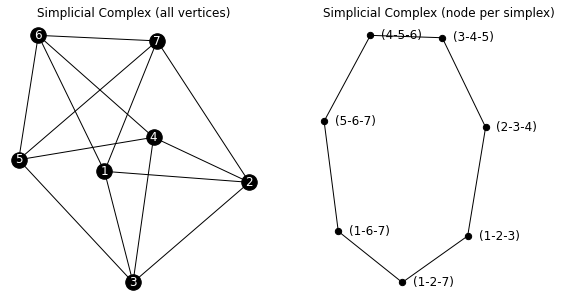

In [256]:
D.manifold.display()

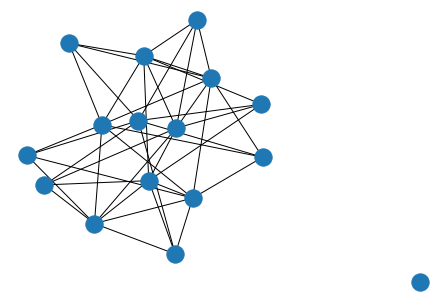

In [257]:
nx.draw(D.manifold.full_G, pos=D.manifold._full_G_pos)

In [259]:
D.manifold.full_G.nodes()

NodeView((1, 2, 3, 4, 5, 6, 7, frozenset({1, 2, 3}), frozenset({2, 3, 4}), frozenset({3, 4, 5}), frozenset({4, 5, 6}), frozenset({5, 6, 7}), frozenset({1, 6, 7}), frozenset({1, 2, 7}), 'SIMPLES', 'SIMPLEX'))

In [332]:
G1_directed = nx.DiGraph()

G1_directed.add_nodes_from(np.arange(6), **{'type': 'vertex'})
G1_directed.add_nodes_from('ABCDEF', **{'type': 'simplex'})

G1_directed.add_edges_from((
    (1, 2), (2, 1), (1, 3), (3, 1), (2, 3), (3, 2),
    (0, 1), (1, 0), (0, 2), (2, 0),
    (3, 4), (4, 3), (2, 3), (3, 2), (2, 4), (4, 2),

    (1, 5), (5, 1), (5, 2), (2, 5), (5, 3), (3, 5),
))
G1_directed.add_edges_from((
    ('A', 1), ('A', 2), ('A', 3),
    ('B', 0), ('B', 1), ('B', 2),
    ('C', 3), ('C', 4), ('C', 2),

    ('D', 1), ('D', 2), ('D', 5),
    ('E', 1), ('E', 5), ('E', 3),
    ('F', 5), ('F', 2), ('F', 3),
))

G1_undirected = nx.Graph()

G1_undirected.add_nodes_from(np.arange(5), **{'type': 'vertex'})
G1_undirected.add_nodes_from('ABCDEF', **{'type': 'simplex'})

G1_undirected.add_edges_from((
    (1, 2), (2, 1), (1, 3), (3, 1), (2, 3), (3, 2),
    (0, 1), (1, 0), (0, 2), (2, 0),
    (3, 4), (4, 3), (2, 3), (3, 2), (2, 4), (4, 2),
    
    (1, 5), (5, 1), (5, 2), (2, 5), (5, 3), (3, 5),
))
G1_undirected.add_edges_from((
    ('A', 1), ('A', 2), ('A', 3),
    ('B', 0), ('B', 1), ('B', 2),
    ('C', 3), ('C', 4), ('C', 2),

    ('D', 1), ('D', 2), ('D', 5),
    ('E', 1), ('E', 5), ('E', 3),
    ('F', 5), ('F', 2), ('F', 3),
))

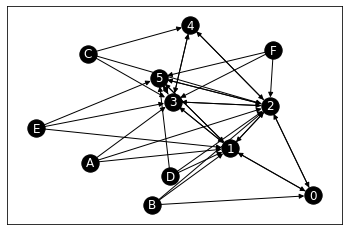

In [333]:
nx.draw_networkx(G1_directed, with_labels=True, arrows=True, node_color='k', font_color='white')

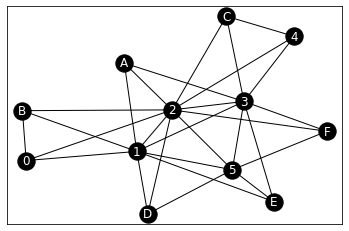

In [334]:
nx.draw_networkx(G1_undirected, with_labels=True, arrows=True, node_color='k', font_color='white')

In [338]:
G2_directed = nx.DiGraph()

G2_directed.add_nodes_from(np.arange(5), **{'type': 'vertex'})
G2_directed.add_nodes_from('ABC', **{'type': 'simplex'})

G2_directed.add_edges_from((
    (1, 2), (2, 1), (1, 3), (3, 1), (2, 3), (3, 2),
    (0, 1), (1, 0), (0, 2), (2, 0),
    (3, 4), (4, 3), (2, 3), (3, 2), (2, 4), (4, 2),
))
G2_directed.add_edges_from((
    ('A', 1), ('A', 2), ('A', 3),
    ('B', 0), ('B', 1), ('B', 2),
    ('C', 3), ('C', 4), ('C', 2),
))


G2_undirected = nx.Graph()

G2_undirected.add_nodes_from(np.arange(5), **{'type': 'vertex'})
G2_undirected.add_nodes_from('ABC', **{'type': 'simplex'})

G2_undirected.add_edges_from((
    (1, 2), (2, 1), (1, 3), (3, 1), (2, 3), (3, 2),
    (0, 1), (1, 0), (0, 2), (2, 0),
    (3, 4), (4, 3), (2, 3), (3, 2), (2, 4), (4, 2),
))
G2_undirected.add_edges_from((
    ('A', 1), ('A', 2), ('A', 3),
    ('B', 0), ('B', 1), ('B', 2),
    ('C', 3), ('C', 4), ('C', 2),
))

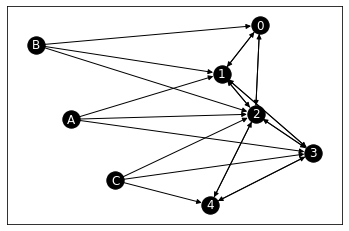

In [339]:
nx.draw_networkx(G2_directed, with_labels=True, arrows=True, node_color='k', font_color='white')

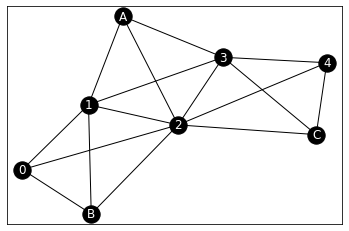

In [340]:
nx.draw_networkx(G2_undirected, with_labels=True, arrows=True, node_color='k', font_color='white')

In [341]:
GM_directed = nx.algorithms.isomorphism.GraphMatcher(G1_directed, G2_directed)
GM_directed.subgraph_is_isomorphic()

list(GM_directed.subgraph_isomorphisms_iter())

[{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 'A': 'A', 'B': 'B', 'C': 'C'},
 {4: 0, 3: 1, 2: 2, 1: 3, 0: 4, 'A': 'A', 'C': 'B', 'B': 'C'}]

In [342]:
GM_undirected = nx.algorithms.isomorphism.GraphMatcher(G1_undirected, G2_undirected)
GM_undirected.subgraph_is_isomorphic()

list(GM_undirected.subgraph_isomorphisms_iter())

[{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 'A', 'B': 'B', 'C': 'C'},
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 'A': 'A', 'B': 'B', 'C': 'C'},
 {0: 0, 1: 1, 2: 2, 3: 3, 'C': 4, 5: 'A', 'B': 'B', 4: 'C'},
 {0: 0, 1: 1, 2: 2, 3: 3, 'C': 4, 'A': 'A', 'B': 'B', 4: 'C'},
 {4: 0, 3: 1, 2: 2, 1: 3, 0: 4, 5: 'A', 'C': 'B', 'B': 'C'},
 {4: 0, 3: 1, 2: 2, 1: 3, 0: 4, 'A': 'A', 'C': 'B', 'B': 'C'},
 {4: 0, 3: 1, 2: 2, 1: 3, 'B': 4, 5: 'A', 'C': 'B', 0: 'C'},
 {4: 0, 3: 1, 2: 2, 1: 3, 'B': 4, 'A': 'A', 'C': 'B', 0: 'C'},
 {'B': 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 'A', 0: 'B', 'C': 'C'},
 {'B': 0, 1: 1, 2: 2, 3: 3, 4: 4, 'A': 'A', 0: 'B', 'C': 'C'},
 {'B': 0, 1: 1, 2: 2, 3: 3, 'C': 4, 5: 'A', 0: 'B', 4: 'C'},
 {'B': 0, 1: 1, 2: 2, 3: 3, 'C': 4, 'A': 'A', 0: 'B', 4: 'C'},
 {'C': 0, 3: 1, 2: 2, 1: 3, 0: 4, 5: 'A', 4: 'B', 'B': 'C'},
 {'C': 0, 3: 1, 2: 2, 1: 3, 0: 4, 'A': 'A', 4: 'B', 'B': 'C'},
 {'C': 0, 3: 1, 2: 2, 1: 3, 'B': 4, 5: 'A', 4: 'B', 0: 'C'},
 {'C': 0, 3: 1, 2: 2, 1: 3, 'B': 4, 'A': 'A', 4: 'B', 0: 'C'}]

In [246]:
GM = nx.algorithms.isomorphism.GraphMatcher(D.topic_graph, D.manifold.G)

In [247]:
GM.subgraph_is_isomorphic()

False

In [248]:
next(GM.subgraph_isomorphisms_iter())

StopIteration: 

In [ ]:
G1 = nx.Graph()

G1.add_nodes_

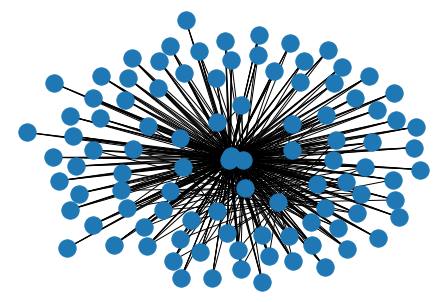

In [245]:
nx.draw(D.topic_graph)

In [221]:
D.viable_topic_sets

[[33, 74, 75],
 [33, 74, 69],
 [33, 74, 52],
 [33, 74, 62],
 [33, 74, 61],
 [33, 74, 97],
 [33, 74, 86],
 [72, 33, 74],
 [33, 74, 54],
 [33, 74, 18],
 [33, 74, 79],
 [8, 33, 74],
 [33, 74, 11],
 [33, 74, 26],
 [33, 74, 45],
 [33, 74, 91],
 [33, 74, 99],
 [33, 74, 46],
 [33, 74, 68],
 [33, 74, 28],
 [33, 74, 22],
 [33, 74, 38],
 [0, 33, 74],
 [33, 74, 25],
 [33, 74, 53],
 [33, 74, 71],
 [33, 74, 15],
 [33, 74, 83],
 [33, 74, 58],
 [33, 74, 67],
 [33, 74, 4],
 [33, 74, 90],
 [33, 74, 98],
 [80, 33, 74],
 [33, 75, 12],
 [33, 12, 69],
 [33, 12, 52],
 [33, 12, 62],
 [33, 43, 12],
 [33, 12, 61],
 [33, 12, 97],
 [33, 12, 29],
 [64, 33, 12],
 [33, 12, 86],
 [72, 33, 12],
 [33, 12, 54],
 [33, 12, 79],
 [8, 33, 12],
 [33, 18, 12],
 [33, 12, 41],
 [33, 26, 12],
 [33, 12, 45],
 [33, 91, 12],
 [33, 99, 12],
 [33, 12, 68],
 [33, 12, 28],
 [33, 12, 38],
 [0, 33, 12],
 [33, 12, 5],
 [33, 12, 25],
 [33, 12, 53],
 [33, 12, 13],
 [33, 12, 71],
 [33, 58, 12],
 [33, 12, 15],
 [33, 12, 6],
 [33, 12, 4],
 [7

In [223]:
G2 = nx.Graph()
G2.add_nodes_from(np.arange(len(D.viable_topic_sets)))
G2.add_edges_from([
    (i1, i2) for (i1, t1), (i2, t2) in itertools.combinations(enumerate(D.viable_topic_sets), 2) if len(set(t1).intersection(t2)) == 2
])

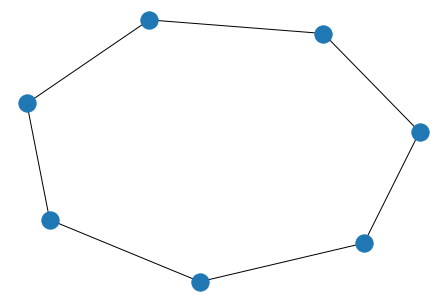

In [224]:
nx.draw(G1)

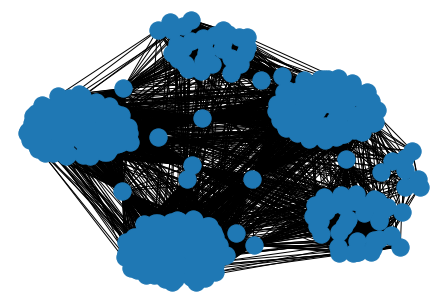

In [225]:
for subgraph

nx.draw(G2)

In [230]:
list(G2.edges())[0]

(0, 1)

In [231]:
GM = nx.algorithms.isomorphism.GraphMatcher(G2, G1)

In [232]:
GM.subgraph_is_isomorphic()

True

In [234]:
next(GM.subgraph_isomorphisms_iter())

{0: 0, 1: 1, 35: 2, 36: 3, 267: 4, 268: 5, 174: 6}

In [238]:
for a in GM.subgraph_isomorphisms_iter():
    print(a)
    break

{0: 0, 1: 1, 35: 2, 36: 3, 267: 4, 268: 5, 174: 6}


In [ ]:
        self._seed(seed, "Match Topic-sets to Simplices")
                
        if tsets is None: tsets = copy.deepcopy(list(self.viable_topic_sets))
        if simplices is None: simplices = copy.deepcopy(list(self.manifold.simplices))
        if already_mapped is None: already_mapped = {}
        
        if len(tsets) == 0 or len(simplices) == 0: return True, already_mapped
        
        # Add some randomness so (if possible) we get different matchings.
        random.shuffle(tsets)
        random.shuffle(simplices)
            
        t_vertices = set(tsets[0]).union(*tsets[1:])
        s_vertices = set(simplices[0]).union(*simplices[1:])
        
        if len(tsets) < len(simplices) or len(t_vertices) < len(s_vertices):
            print("Whoops!")
            return False, already_mapped
        
        s_to_t_map = already_mapped
        t_to_s_map = {t: s for s, t in already_mapped.items()}
        
        simplex, simplices_next = simplices[0], simplices[1:]
        s_known_in_t = set(s_to_t_map[s] for s in set(simplex) if s in s_to_t_map)
        
        matched = False
        for tset_j, tset in enumerate(tsets):
            if s_known_in_t - set(tset): continue

            t_known_in_s = set(t_to_s_map[t] for t in tset if t in t_to_s_map)
            if t_known_in_s - set(simplex): continue

            assert len(s_known_in_t) == len(t_known_in_s)
            # Now that we've found a potential matching, let's see if it works with other downstream matchings.
            # If not, we'll discard it and try again.
            already_mapped_next = copy.deepcopy(s_to_t_map)
            
            for s, t in zip(set(simplex) - t_known_in_s, set(tset) - s_known_in_t):
                already_mapped_next[s] = t

            tsets_next = tsets[:tset_j] + tsets[tset_j+1:]
            matched, mapping = self._match_tsets_to_simplices(tsets_next, simplices_next, already_mapped_next)
            
            if matched: return True, mapping    

        return False, already_mapped

In [ ]:
D.display(do_print=False)

In [13]:
DO_OVERWRITE = False

output_dir_base = Path("/crimea/graph_augmented_pt/runs/synthetic_exp_3/manifolds/mobius/1")
if not output_dir_base.exists(): os.makedirs(output_dir_base)

graph_gen_kwargs = dict(
    manifold                 = mobius_kwargs,
    raw_topic_probabilities  = topics,
    raw_sents                = text_data,
    dataset_size             = 5000,
    seed                     = 1,
    topic_thresh             = 0.67,
    subsample_data           = -1,
    num_entropy_buckets    = 100,
    num_samples_per_bucket = 10,
    manifold_radius_graph_r  = 0.6,
)

if not (output_dir_base / 'graph_gen_kwargs.pkl').exists():
    with open(output_dir_base / 'graph_gen_kwargs.pkl', mode='wb') as f:
        pickle.dump(graph_gen_kwargs, f)

results = {}
dataset_seeds_all = {}
model_metadata_all = {}

gml_head = EUCLIDEAN_DISTANCE
for gml_weight in tqdm((0.9, 0.5, 0.1, 1.0, 0), desc="GML Weight", leave=False):
    point_weight = 1 - gml_weight

    times = [("Start", time.time())]

    output_dir = output_dir_base / gml_head / f"gml_weight_{gml_weight}"

    if os.path.isdir(output_dir):
        results_filepath = output_dir / "run_stats.json"
        mm_filepath = output_dir / 'model_metadata.json'
        ds_filepath = output_dir / 'dataset_seeds.json'
        
        if results_filepath.exists() and mm_filepath.exists() and ds_filepath.exists():
            with open(results_filepath, mode='r') as f:
                results[gml_head] = (json.loads(f.read()), None)
            with open(mm_filepath, mode='r') as f:
                model_metadata_all[gml_head] = (json.loads(f.read()), None)
            with open(ds_filepath, mode='r') as f:
                dataset_seeds_all[gml_head] = (json.loads(f.read()), None)
            continue

        if DO_OVERWRITE: 
            print(f"Overwriting {output_dir}")
            shutil.rmtree(output_dir)
            os.makedirs(output_dir)
    else: os.makedirs(output_dir)

    times.append(("Directories Done", time.time()))

    dataset = ManifoldNearestNeighborDataset(**graph_gen_kwargs)
    dataset.num_dataloader_workers = 0 # For synthetic data, this is way faster.

    times.append(("Dataset Made", time.time()))

    accum, models, model_metadata, dataset_seeds = run_synthetic(
        output_dir                    = output_dir,
        synthetic_dataset             = dataset,
        gml_head                      = gml_head,
        gml_weight                    = gml_weight,
        point_weight                  = point_weight,
        print_first                   = 0,
        do_plot                       = False,
        tqdm                          = lambda *args, **kwargs: tqdm(*args, **kwargs, leave=False),
        num_epochs                    = 5000,
        num_samples                   = 5,
        re_gen_data_in_between        = True,
        neighbor_prediction_eval_freq = 100,
        weights_summary               = None,
        do_checkpointing              = False,
        progress_bar_refresh_rate     = 0,
        do_overwrite                  = DO_OVERWRITE,
    )

    times.append(("Run Complete", time.time()))

    res_dict = {k: accum.mean_std(k) for k in accum.run_stats}

    with open(output_dir / "run_stats.json", mode='w') as f:
        f.write(json.dumps(res_dict, indent=2))
    with open(output_dir / "model_metadata.json", mode='w') as f:
        f.write(json.dumps([str(v) for v in model_metadata], indent=2))
    with open(output_dir / "dataset_seeds.json", mode='w') as f:
        f.write(json.dumps(dataset_seeds, indent=2))

    times.append(("End", time.time()))
    results[gml_weight] = (res_dict, times)
    model_metadata_all[gml_weight] = model_metadata
    dataset_seeds_all[gml_weight] = dataset_seeds

Attempting topic arrangment 1...


Attempting topic arrangment 2...


Attempting topic arrangment 3...


Attempting topic arrangment 4...


Attempting topic arrangment 5...


Attempting topic arrangment 1...


Attempting topic arrangment 2...


Attempting topic arrangment 3...


Attempting topic arrangment 4...


Attempting topic arrangment 5...


Attempting topic arrangment 6...


Attempting topic arrangment 7...


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


RuntimeError: CUDA out of memory. Tried to allocate 4.23 GiB (GPU 0; 23.65 GiB total capacity; 4.72 GiB already allocated; 1.60 GiB free; 4.74 GiB reserved in total by PyTorch)